# Market Basket Analysis

### **Objetivos de negocio**
El verdadero objetivo es rentabilizar los datos de los que disponemos. Concretamente queremos usar algoritmos de asociación para generar reglas de asociación que pueden ser usadas para:
- **Posicionamiento de productos**. Identificar productos que habitualmente se compran juntos para situarlos cerca en las páginas webs o los catálogos (y así animar a la compra).
- **Posicionamiento de productos en tiendas físicas**. Situar a los productos que se compran juntos en la misma estantería o en estanterías cercanas. 
- **Up-selling, cross-selling y bundling**. Recomendar productos con mejores márgenes, productos complementarios u ofrecer paquetes de productos (usualmente con un descuento).

### **Plan de proyecto**
- Realizar un análisis exploratorio de los datos.
- Usar el algoritmo a priori para generar reglas de asociación.
- Extraer conclusiones significativas aplicadas al negocio.
- Elaborar un presupuesto para el proyecto.

### **Conceptos previos**
- **Support:** Indicador de con qué frecuencia un objeto (o conjunto de objetos) aparece en el conjunto de datos.
- **Confidence:** Para una regla de asociación "X => Y", la confianza muestra el porcentaje en el que Y es comprada junto con X. Es decir, es un indicador de la frecuencia con la que se cumple dicha regla.
- **Lift:** El "lift" de una regla "X => Y" es el ratio del soporte observado y el soporte esperado si X e Y fueran independientes.
    - Si Lift > 1 : X e Y aparecen juntos más frecuentemente de lo esperado, por lo tanto ambas ocurrencias son dependientes la una de la otra.
    - Si Lift = 1 : La probabilidad de ocurrencia de X e Y son independientes la una de la otra y no se pueden derivar reglas.
    - Si Lift > 1 : X e Y aparecen juntos menos frecuentemente de lo esperado, por lo tanto ambas ocurrencias son dependientes la una de la otra.

### **Entendiendo el dataset**
Disponemos de 21292 observaciones que representan transacciones de la compra de un producto. Para transacciones con varios productos, encontramos varias entradas en la tabla (una para cada producto).
- Variable **"Date"**: Fecha de transacción en formato "YYYY-MM-DD".
- Variable **"Time"**: Hora de transacción en formato "HH:MM:SS".
- Variable **"Transaction"**: Identifica qué productos se compraron en la misma transacción.
- Variable **"Item"**: Producto que se compró durante la transacción.

El resto de variables son los posibles alimentos y su columna indica con un "1" si apareció en la transacción o con un "0" si no. Es decir, fue una variable categórica a la que se le aplicó One Hot Encoding. 

## Preparaciones

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import itertools
from mlxtend.frequent_patterns import apriori, association_rules

In [25]:
# Cargamos el dataset
transacciones_df = pd.read_csv("Transacciones_raw.csv", index_col=0)

In [26]:
transacciones_df.head()

,Time,Transaction,Item
Date,,,
2016-10-30,09:58:11,1,Bread
2016-10-30,10:05:34,2,Scandinavian
2016-10-30,10:05:34,2,Scandinavian
2016-10-30,10:07:57,3,Hot chocolate
2016-10-30,10:07:57,3,Jam


In [27]:
transacciones_df.tail()

,Time,Transaction,Item
Date,,,
2017-04-09,14:32:58,9682,Coffee
2017-04-09,14:32:58,9682,Tea
2017-04-09,14:57:06,9683,Coffee
2017-04-09,14:57:06,9683,Pastry
2017-04-09,15:04:24,9684,Smoothies


In [28]:
transacciones_df.shape

(21293, 3)

Tenemos 21293 filas y 3 columnas. 

También comprobamos que tenemos un total de 95 productos únicos.

In [29]:
# Comprobamos los tipos de las columnas
transacciones_df.dtypes

Time           object
Transaction     int64
Item           object
dtype: object

Las columnas "Date" y "Time" son strings y queremos convertirlas a tipo "datetime".

In [30]:
transacciones_df.index =  pd.to_datetime(transacciones_df.index , format='%Y-%m-%d')
transacciones_df['Time'] =  pd.to_datetime(transacciones_df['Time'], format='%H:%M:%S')

In [31]:
transacciones_df.dtypes

Time           datetime64[ns]
Transaction             int64
Item                   object
dtype: object

In [32]:
transacciones_df.describe()

,Transaction
count,21293.000000
mean,4951.990889
std,2787.758400
min,1.000000
25%,2548.000000
50%,5067.000000
75%,7329.000000
max,9684.000000


C:\Users\juani\miniconda3\envs\env1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


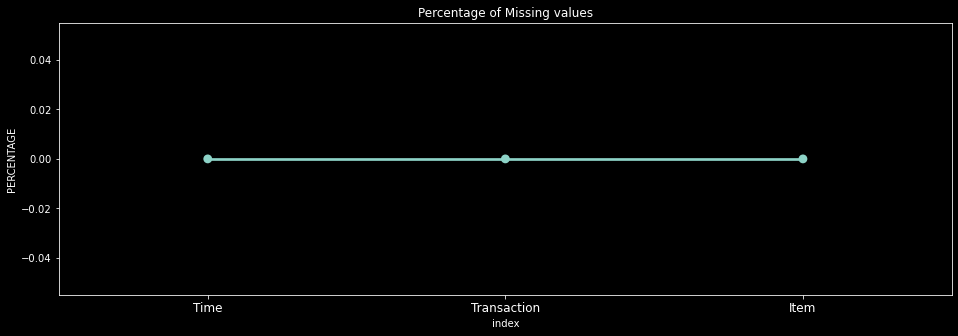

In [33]:
# Comprobamos los NaN por columna
missing = pd.DataFrame((transacciones_df.isnull().sum())*100/transacciones_df.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot('index',0,data=missing)
plt.xticks(fontsize =12)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

In [34]:
# Comprobamos si hay entradas repetidas
transacciones_df[transacciones_df.duplicated(subset=None, keep=False) == True]

,Time,Transaction,Item
Date,,,
2016-10-30,1900-01-01 10:05:34,2,Scandinavian
2016-10-30,1900-01-01 10:05:34,2,Scandinavian
2016-10-30,1900-01-01 10:27:21,11,Bread
2016-10-30,1900-01-01 10:27:21,11,Bread
2016-10-30,1900-01-01 10:34:36,15,NONE
...,...,...,...
2017-04-08,1900-01-01 16:30:32,9634,Coffee
2017-04-09,1900-01-01 11:40:10,9664,Coffee
2017-04-09,1900-01-01 11:40:10,9664,Coffee


Podemos observar que hay 3206 entradas repetidas (es decir sobran 1603 entradas). 

¿Tiene sentido que la misma transacción aparezca 2 veces? Podría interpretarse como que se compran 2 unidadesd el mismo objeto en la misma transacción.

Esto sin embargo alterará los resultados del análisis y es algo que en el ejemplo actual no consideraremos; por tanto lo tratamos como un error y eliminamos las duplicadas.


In [35]:
transacciones_df.drop_duplicates(keep='first', inplace= True)


In [36]:
transacciones_df[transacciones_df["Item"] == 'NONE']

,Time,Transaction,Item
Date,,,
2016-10-30,1900-01-01 10:27:21,11,NONE
2016-10-30,1900-01-01 10:34:36,15,NONE
2016-10-30,1900-01-01 11:05:30,29,NONE
2016-10-30,1900-01-01 11:37:10,37,NONE
2016-10-30,1900-01-01 11:55:51,40,NONE
...,...,...,...
2017-04-08,1900-01-01 11:54:22,9590,NONE
2017-04-08,1900-01-01 12:58:25,9599,NONE
2017-04-09,1900-01-01 12:01:07,9666,NONE


Observamos la existencia de una columna 'NONE' que sí tiene entradas. No queda claro que significa, dado que no tiene sentido que se lleve a cabo una transacción sin objeto (¿o sí?). Dado que en principio no molesta, mantendremos la columna durante el análisis.

## Exploración

Ahora que hemos realizado un estudio preeliminar y estamos familiarizados con los datos, pasamos a explorar los mismos.

**Análisis Univariable**

### ¿Cúales son los productos más frecuentes?

In [37]:
products_df = transacciones_df.groupby(['Item'])["Item"].count().reset_index(name='Count')

In [38]:
products_df.sort_values('Count', ascending=False)

,Item,Count
23,Coffee,4528
11,Bread,3097
84,Tea,1350
15,Cake,983
66,Pastry,815
...,...,...
19,Chicken sand,1
41,Gift voucher,1
64,Olum & polenta,1
72,Raw bars,1


<AxesSubplot:xlabel='Item', ylabel='Count'>

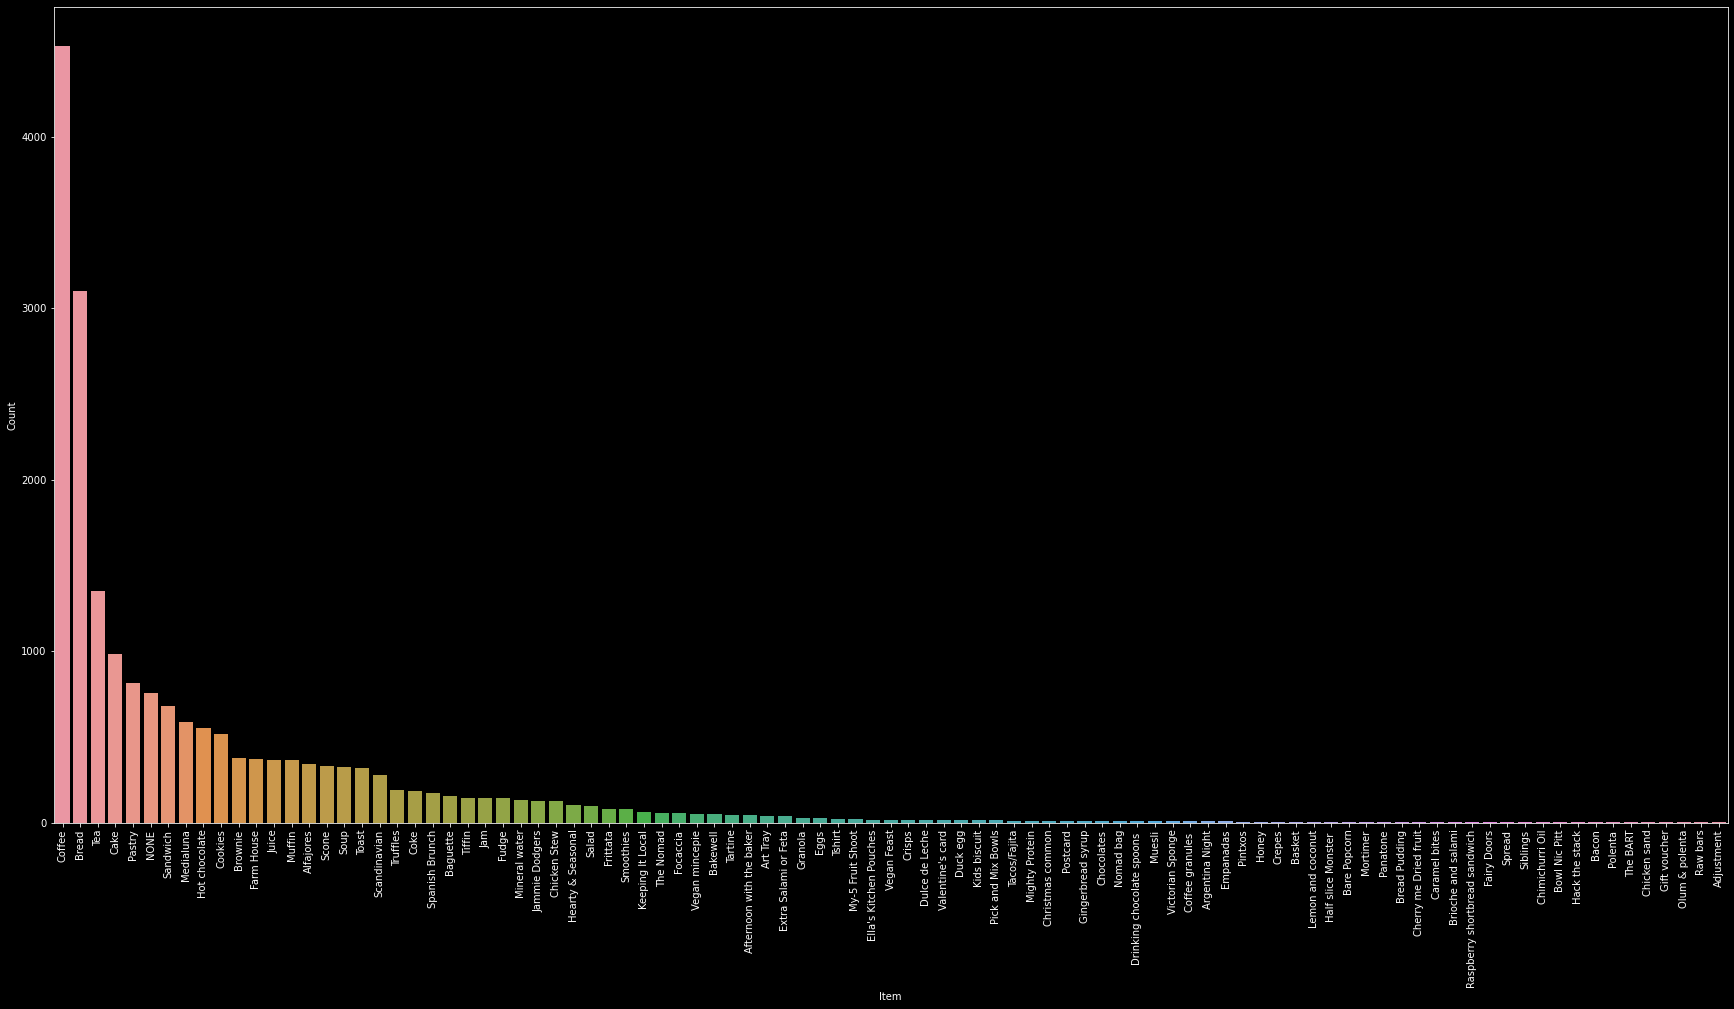

In [39]:
plt.figure(figsize=(30,15))
plt.xticks(rotation=90)
sns.barplot(x='Item', y="Count", data=products_df, order=products_df.sort_values('Count', ascending=False)['Item'])

### ¿Cuántos productos se compran por transacción?

In [40]:
products_per_transaction = transacciones_df.groupby(['Transaction'])["Item"].count().reset_index(name='Count')
products_per_transaction.sort_values("Count", ascending=False).head(30).reset_index(drop="True")


,Transaction,Count
0,8835,10
1,9447,10
2,6474,10
3,3673,10
4,6716,9
5,9534,9
6,6412,8
7,5062,8
8,7602,8
9,4933,8


<AxesSubplot:xlabel='Transaction', ylabel='Count'>

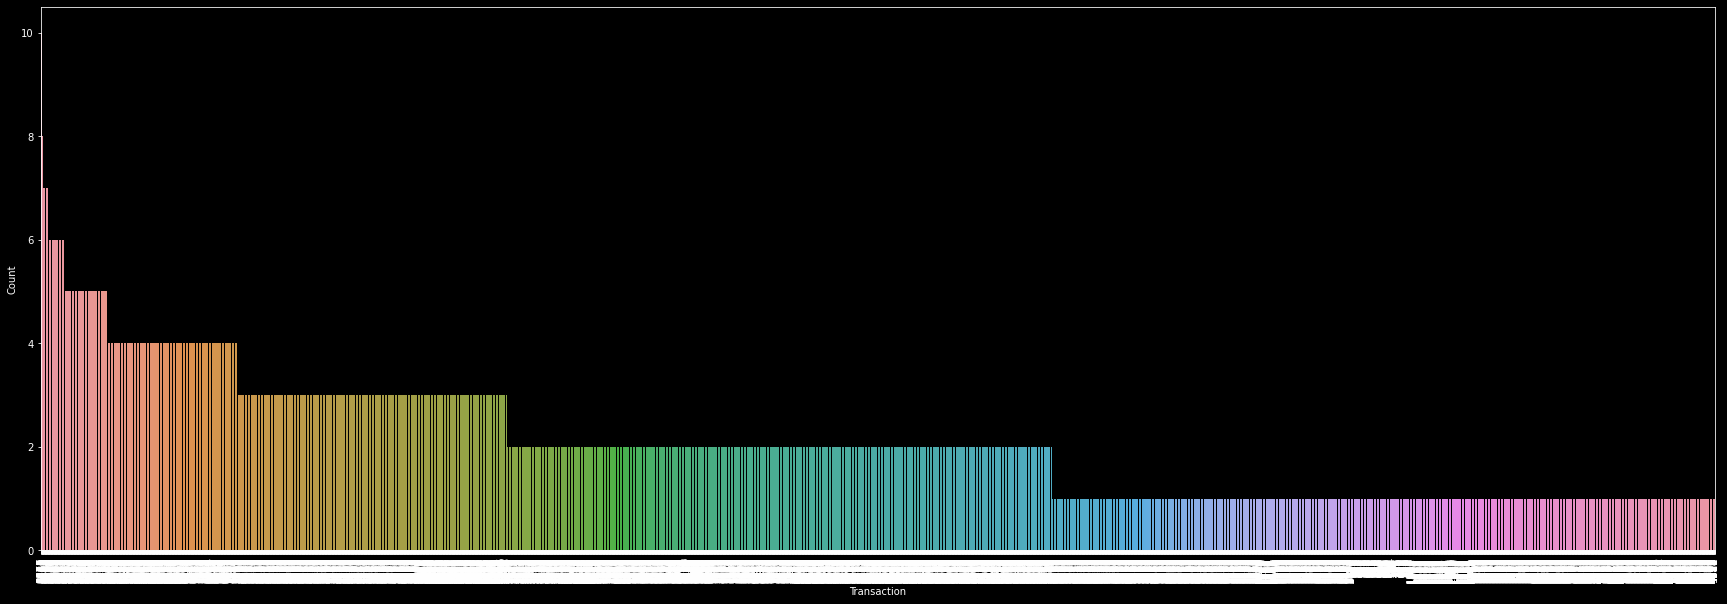

In [41]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
sns.barplot(x='Transaction', y="Count", data=products_per_transaction, order=products_per_transaction.sort_values('Count', ascending=False)['Transaction'])

In [42]:
pie = products_per_transaction.groupby(['Count']).count()
pie


,Transaction
Count,
1,3774
2,3101
3,1537
4,738
5,246
6,96
7,27
8,6
9,2


(-1.1148999987501906,
 1.100709523750009,
 -1.1158254625942263,
 1.1191361698710487)

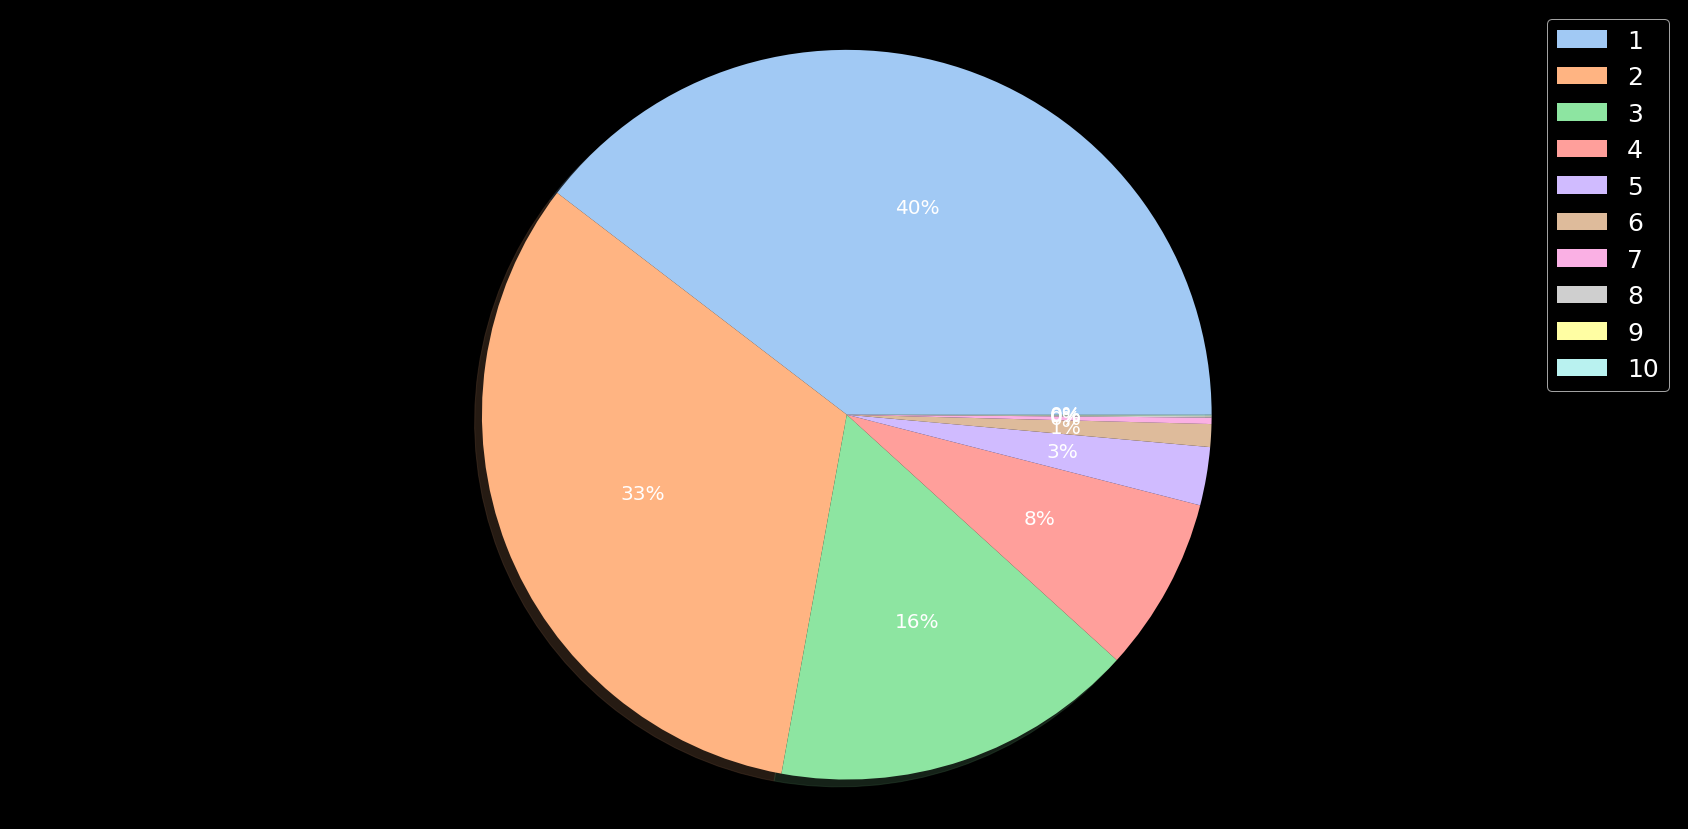

In [43]:
plt.figure(figsize=(30,15))
colors = sns.color_palette('pastel')

patches, texts, autotexts = plt.pie(pie["Transaction"],shadow=True, colors = colors, autopct='%.0f%%', textprops={'fontsize': 20})
plt.legend(patches, pie.index, loc="best", prop={'size': 25})
plt.axis('equal')


### ¿Cuántas transacciones se hacen por día?

In [44]:
transactions_per_day = transacciones_df.groupby(['Date'])["Item"].count().reset_index(name='Count')

In [45]:
transactions_per_day.set_index("Date", inplace=True)
transactions_per_day = transactions_per_day.reindex(pd.date_range('2016-10-30', '2017-04-09'), fill_value=0)
transactions_per_day.sort_values("Count", ascending=False)

,Count
2017-02-04,270
2016-11-05,264
2017-03-04,250
2017-03-25,240
2017-01-28,230
...,...
2016-12-27,45
2017-01-01,1
2016-12-25,0
2016-12-26,0


<AxesSubplot:ylabel='Count'>

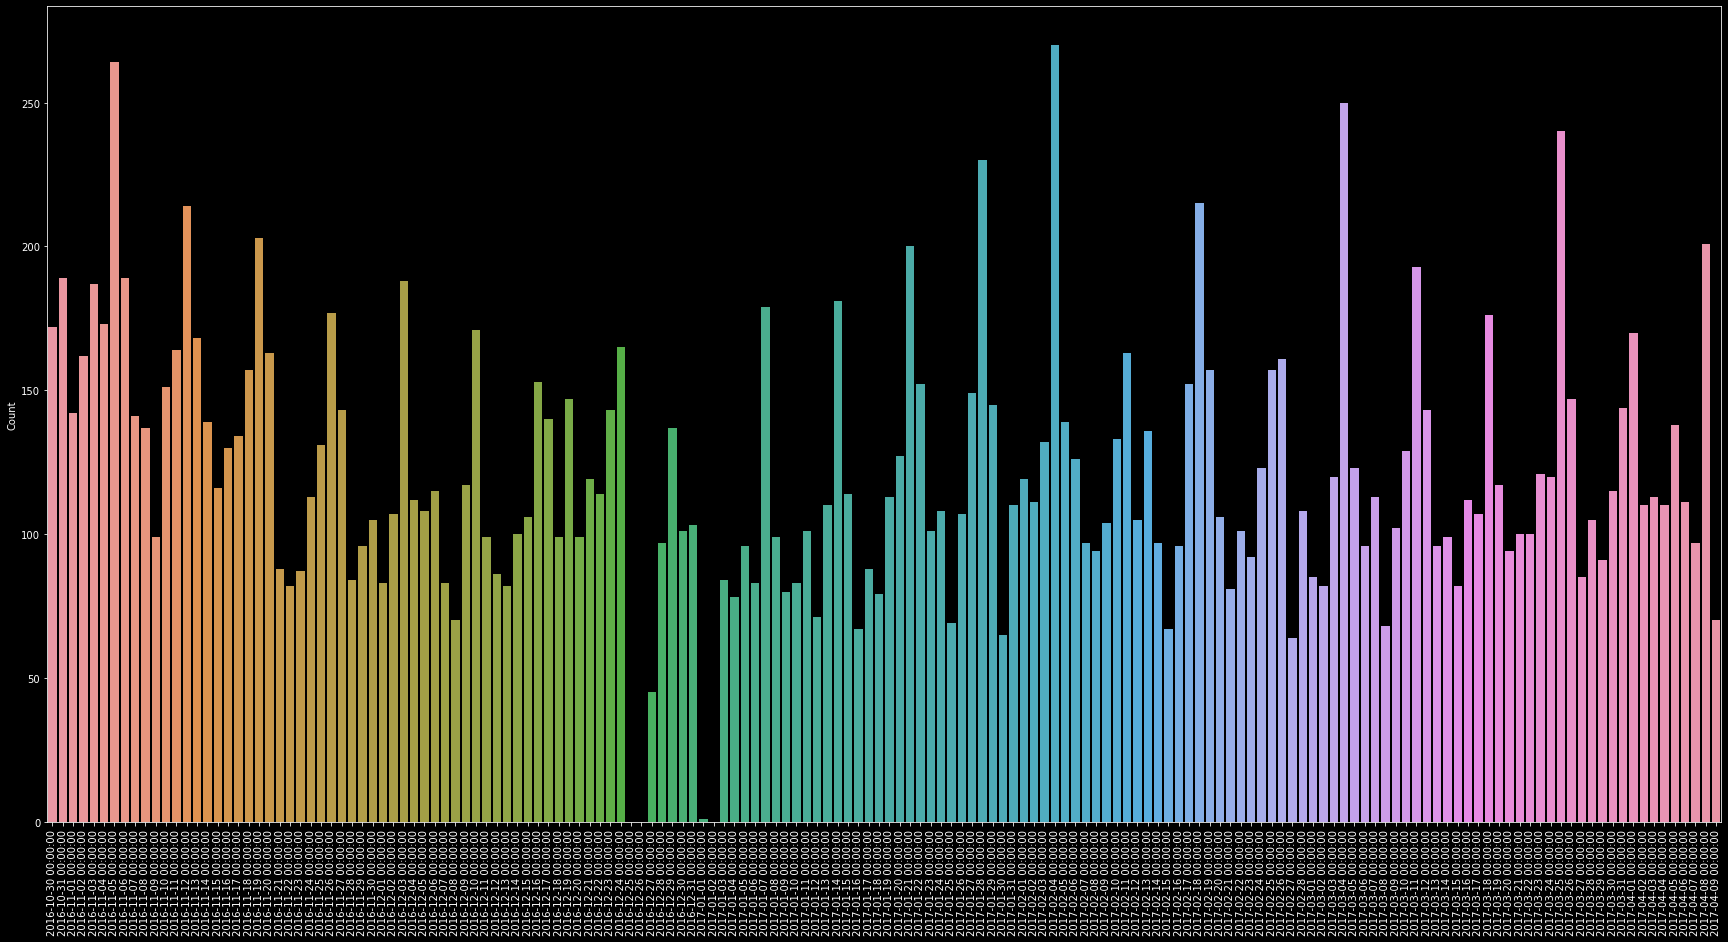

In [46]:
plt.figure(figsize=(30,15))
plt.xticks(rotation=90)
sns.barplot(x=transactions_per_day.index, y="Count", data=transactions_per_day)

### ¿Cómo están repartidas en el tiempo las ventas de los alimentos?

In [47]:
# Primero lo vemos por días
transactions_per_day = transacciones_df.groupby(['Item'])["Item"].count().reset_index(name='Count')
transactions_per_day.sort_values('Count', ascending=False)

,Item,Count
23,Coffee,4528
11,Bread,3097
84,Tea,1350
15,Cake,983
66,Pastry,815
...,...,...
19,Chicken sand,1
41,Gift voucher,1
64,Olum & polenta,1
72,Raw bars,1


In [48]:
# Primero lo vemos por días
transactions_per_day_and_item = transacciones_df.groupby(['Date'])["Item"].value_counts().reset_index(name='Count')
transactions_per_day_and_item

,Date,Item,Count
0,2016-10-30,Coffee,29
1,2016-10-30,Bread,28
2,2016-10-30,Scandinavian,15
3,2016-10-30,Muffin,12
4,2016-10-30,Tea,12
...,...,...,...
3803,2017-04-09,Half slice Monster,1
3804,2017-04-09,Medialuna,1
3805,2017-04-09,Muffin,1
3806,2017-04-09,My-5 Fruit Shoot,1


Coffee
Bread
Tea
Cake
Pastry


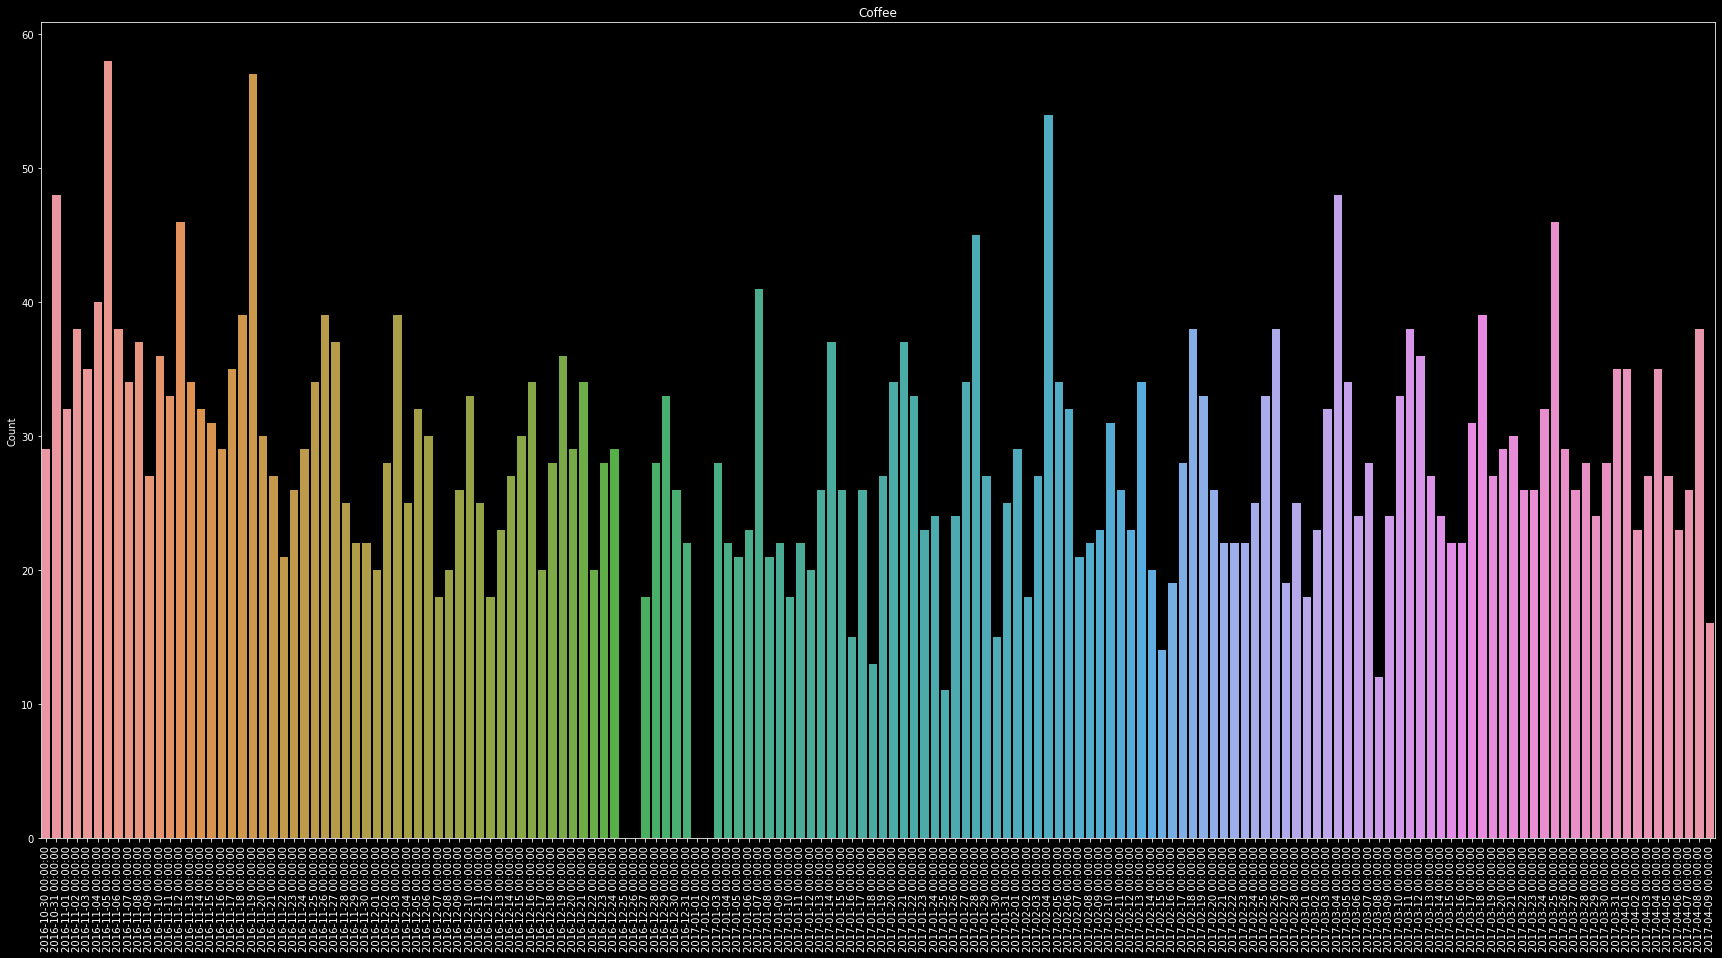

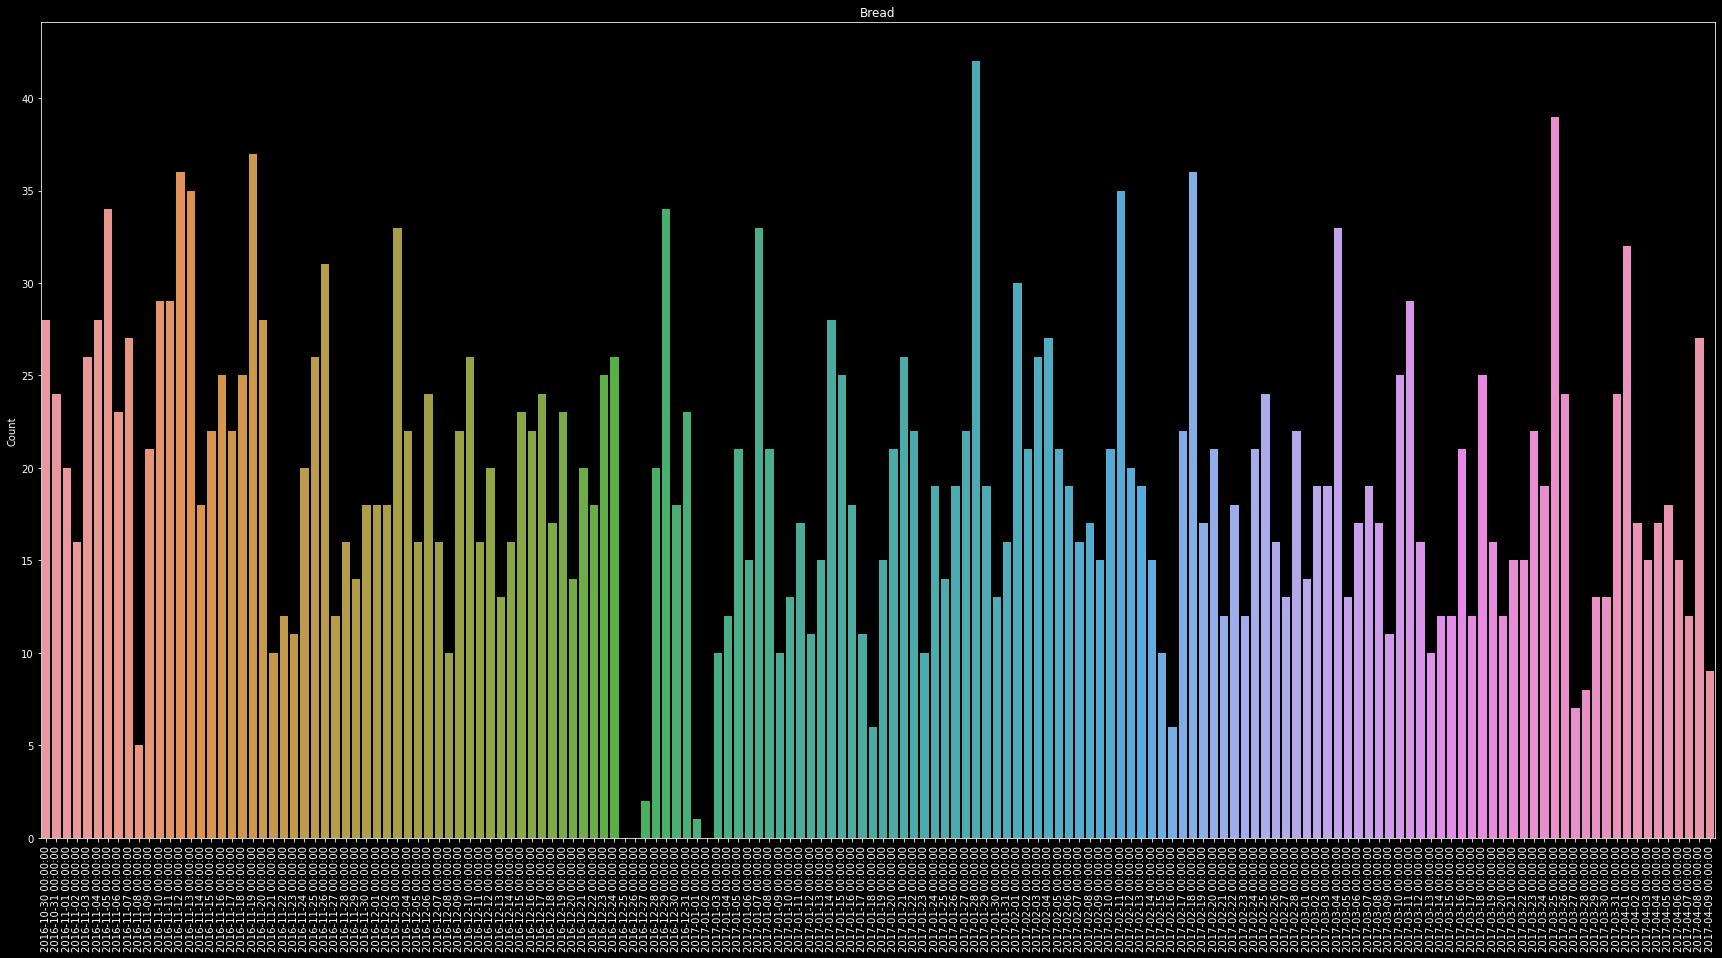

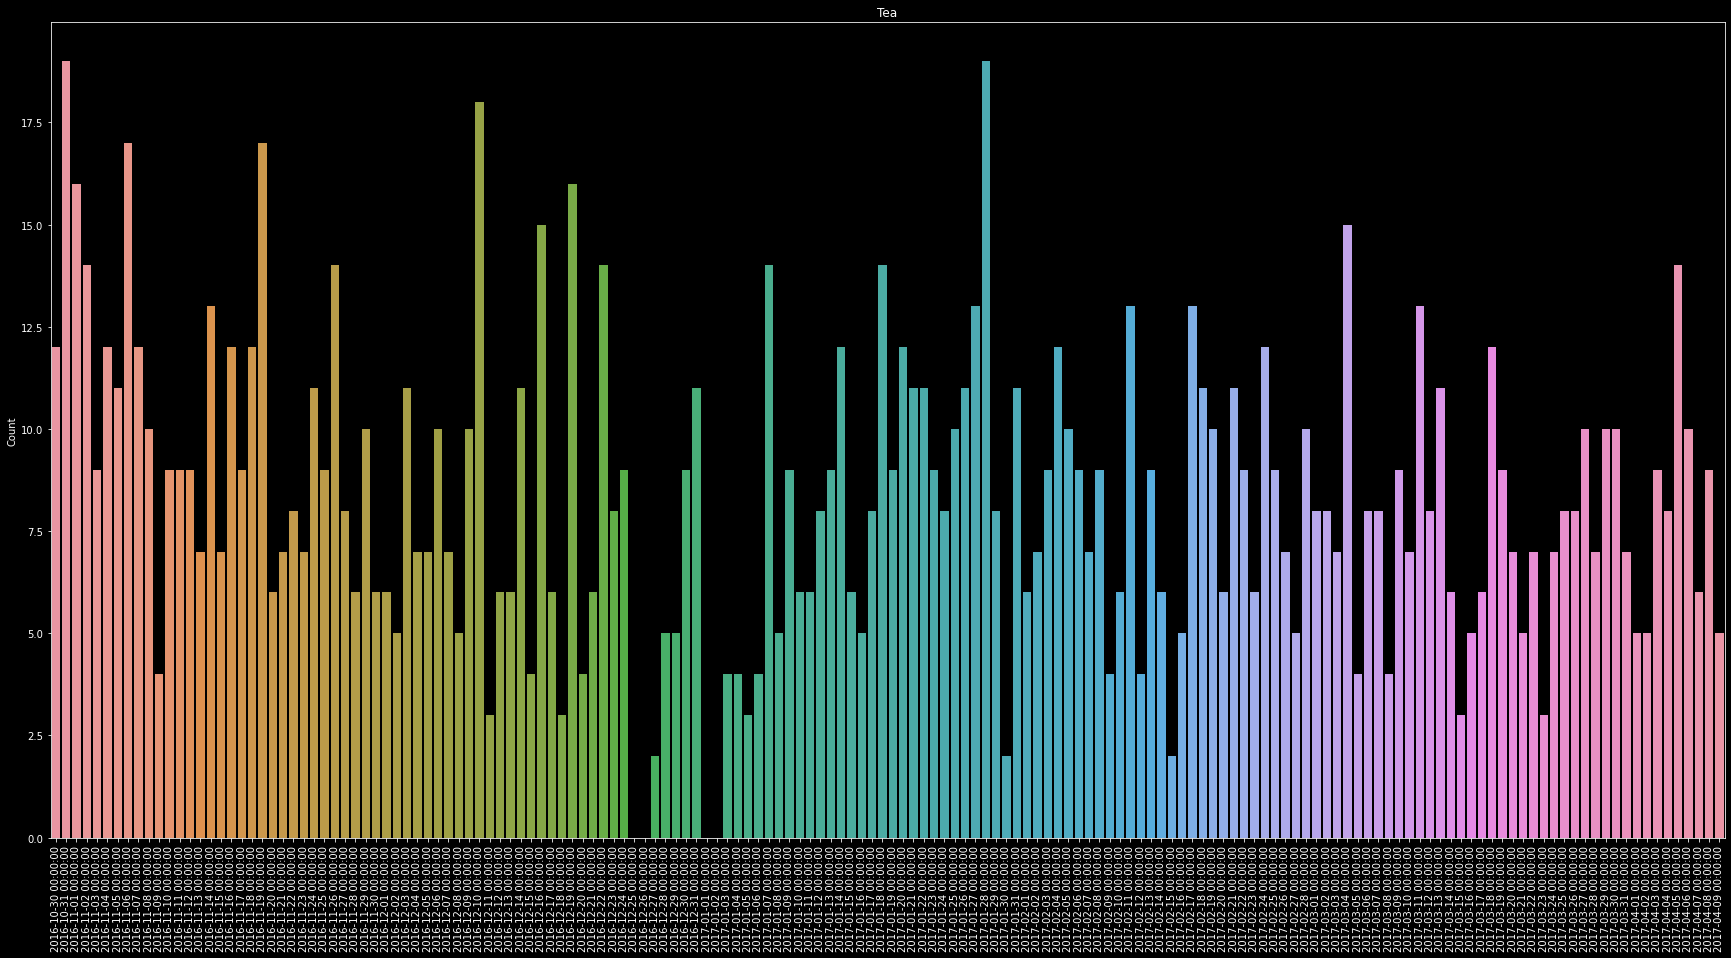

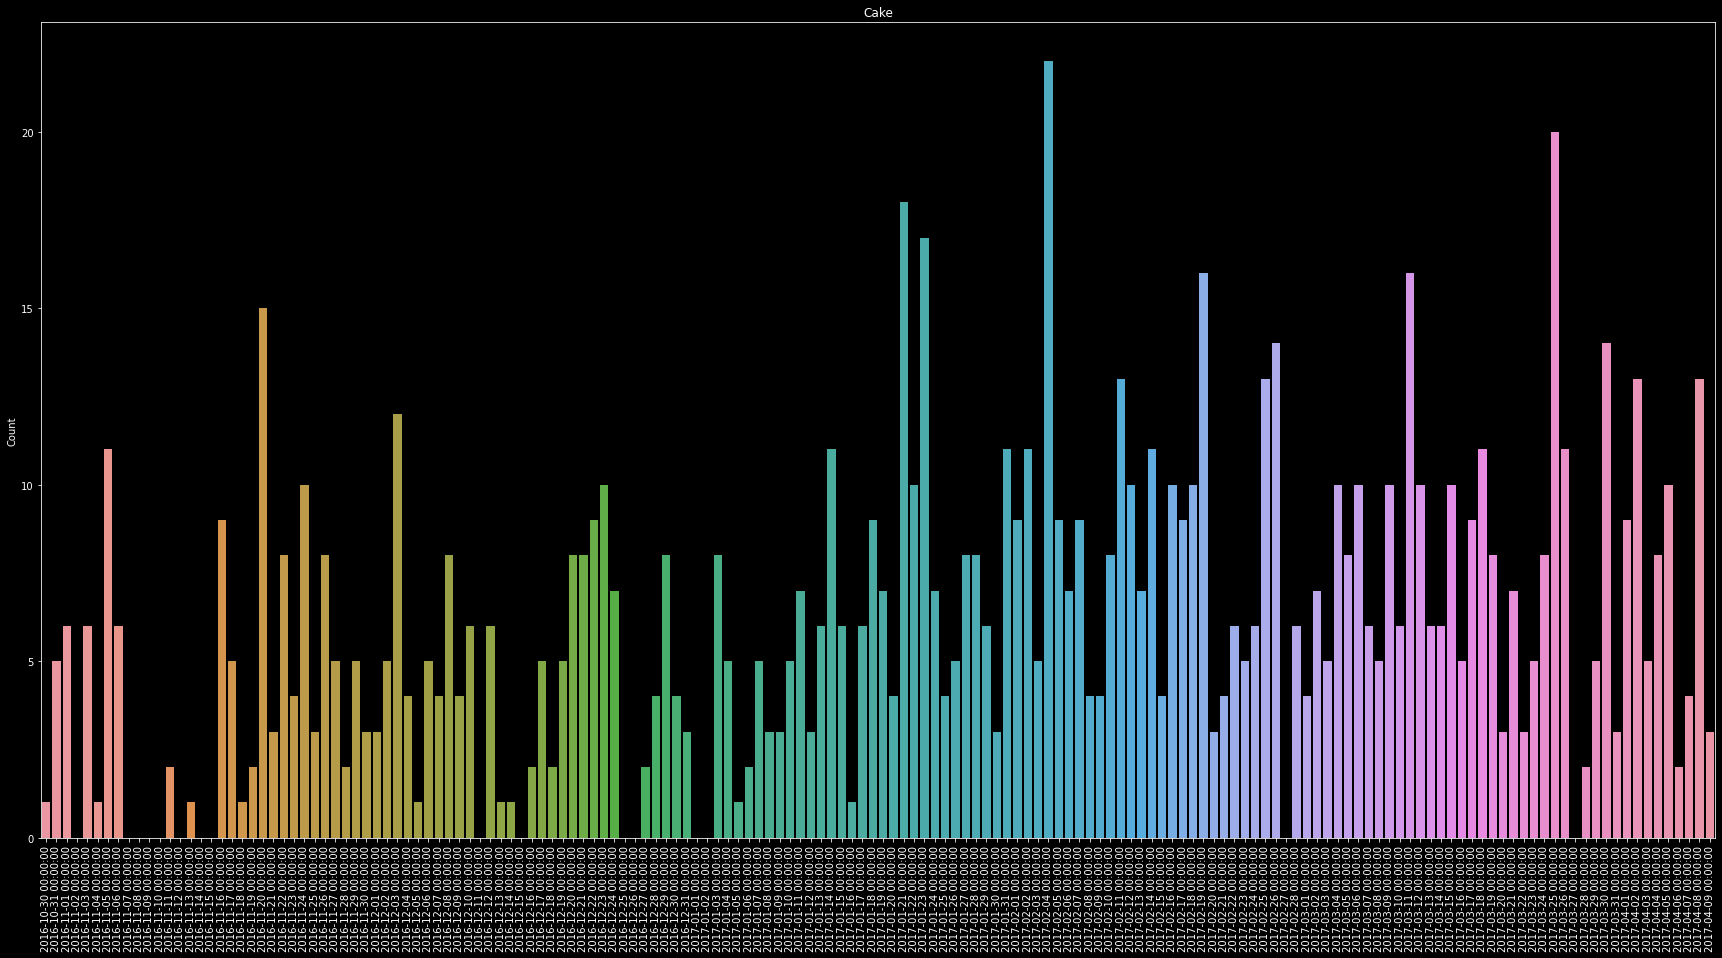

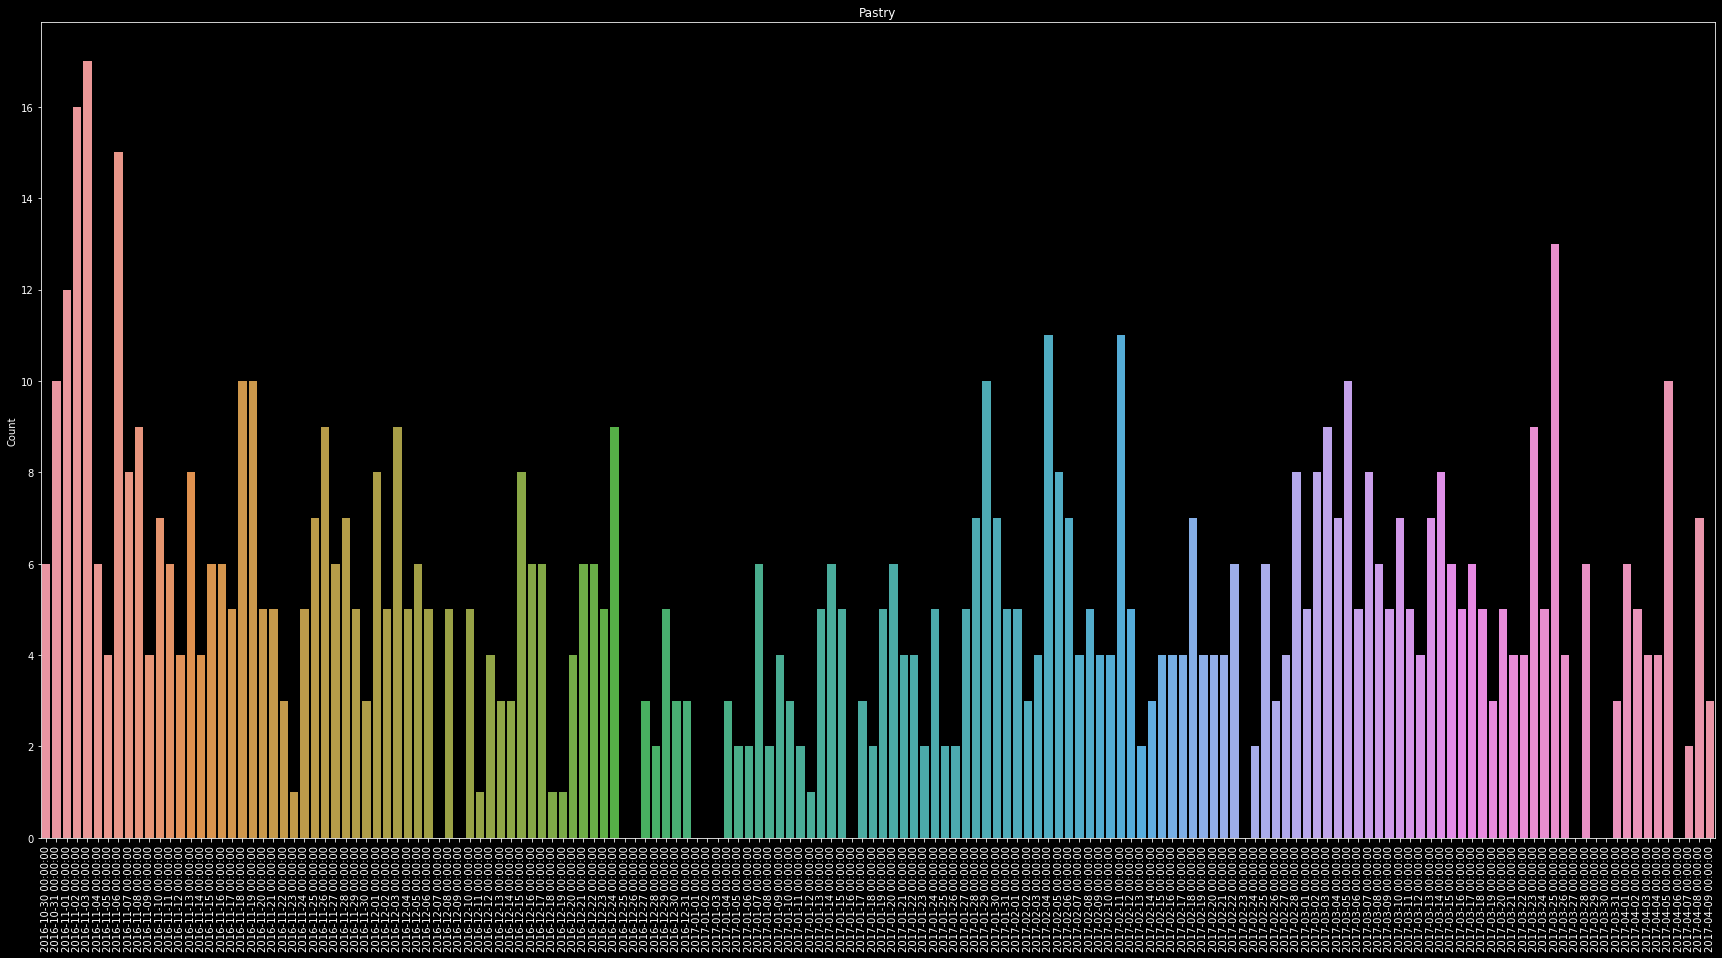

In [49]:

for item in transactions_per_day.sort_values('Count', ascending=False)["Item"].unique()[:5]:
    print(item)
    group_item1 = transactions_per_day_and_item.copy()
    group_item1 = group_item1[group_item1["Item"] == item]
    
    group_item1.set_index("Date", inplace=True)
    group_item1 = group_item1.reindex(pd.date_range('2016-10-30', '2017-04-09'), fill_value=0)
    
    plt.figure(figsize=(30,15))
    plt.xticks(rotation=90)
    sns.barplot(x=group_item1.index, y="Count", data=group_item1).set_title(item)


In [50]:
# ¿Cuál es la diferencia entre semana y el fin de semana?
group_weekday = transacciones_df.groupby(['Date'])["Item"].count().reset_index(name='Count')

group_weekday.set_index("Date", inplace=True)
group_weekday = group_weekday.reindex(pd.date_range('2016-10-30', '2017-04-09'), fill_value=0)
group_weekday

,Count
2016-10-30,172
2016-10-31,189
2016-11-01,142
2016-11-02,162
2016-11-03,187
...,...
2017-04-05,138
2017-04-06,111
2017-04-07,97
2017-04-08,201


In [51]:
group_weekday["Weekday"] = group_weekday.index.map(lambda x: x.weekday())
group_weekday["WeekdayName"] = group_weekday["Weekday"].map({0:"Lunes", 1:"Martes", 2:"Miércoles", 3:"Jueves", 4:"Viernes", 5:"Sábado", 6:"Domingo"})

In [52]:
group_weekday

,Count,Weekday,WeekdayName
2016-10-30,172,6,Domingo
2016-10-31,189,0,Lunes
2016-11-01,142,1,Martes
2016-11-02,162,2,Miércoles
2016-11-03,187,3,Jueves
...,...,...,...
2017-04-05,138,2,Miércoles
2017-04-06,111,3,Jueves
2017-04-07,97,4,Viernes
2017-04-08,201,5,Sábado


<AxesSubplot:xlabel='WeekdayName', ylabel='Count'>

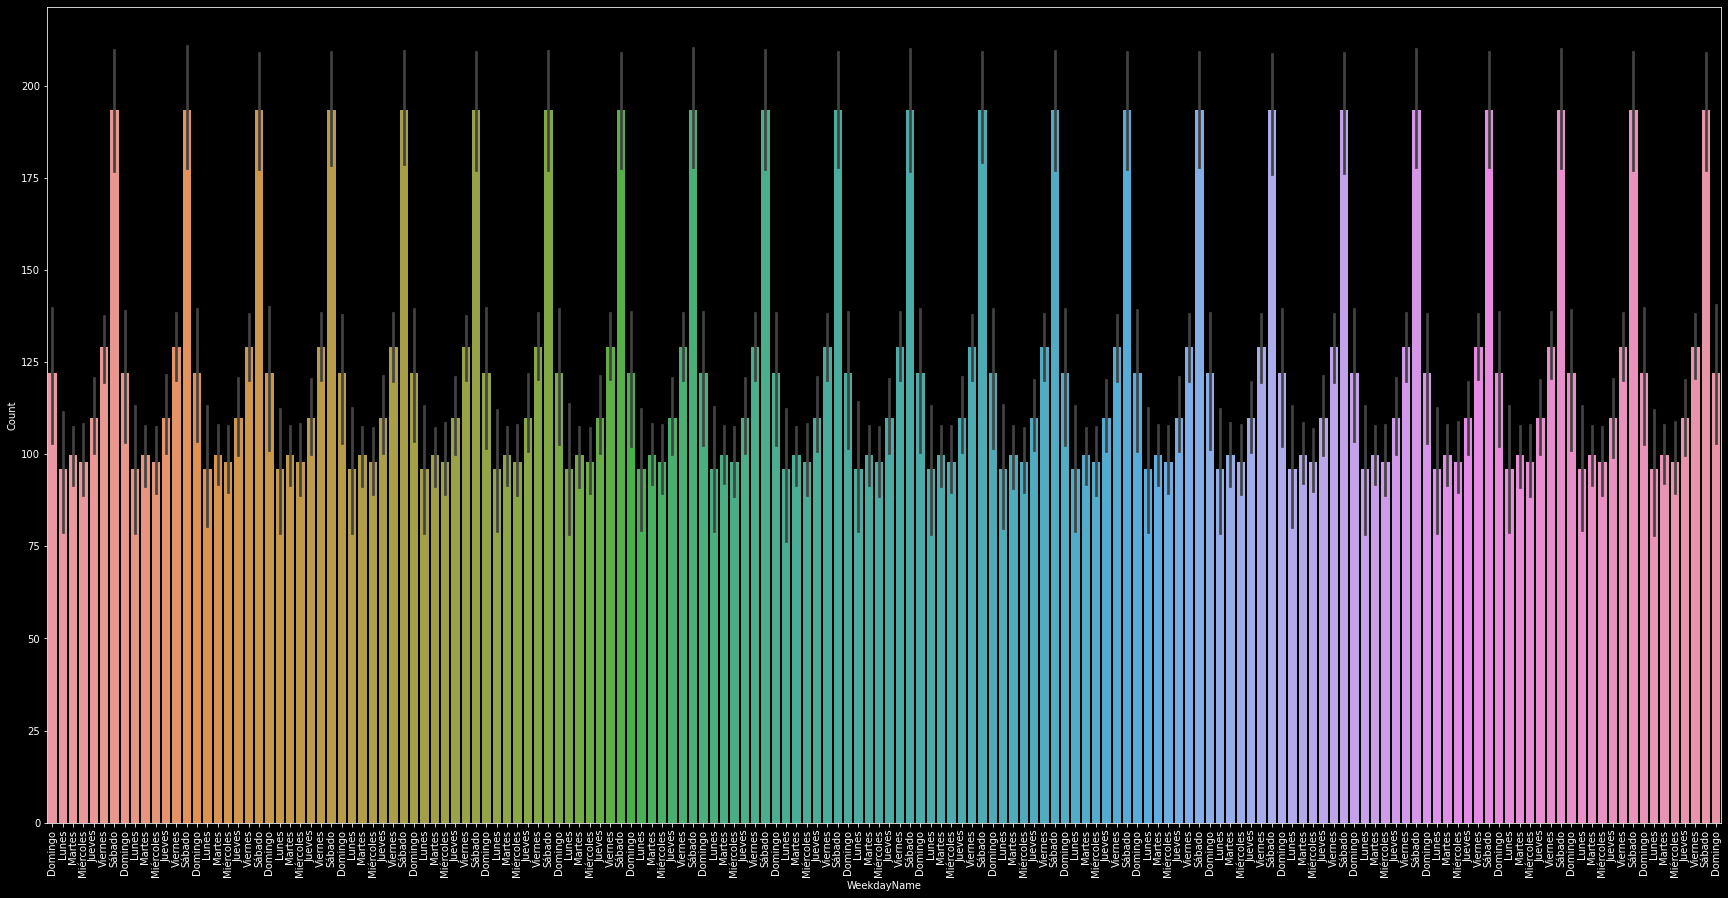

In [53]:
plt.figure(figsize=(30,15))
plt.xticks(rotation=90)
sns.barplot(x="WeekdayName", y="Count", data=group_weekday, order=group_weekday['WeekdayName'])

<AxesSubplot:xlabel='WeekdayName', ylabel='Count'>

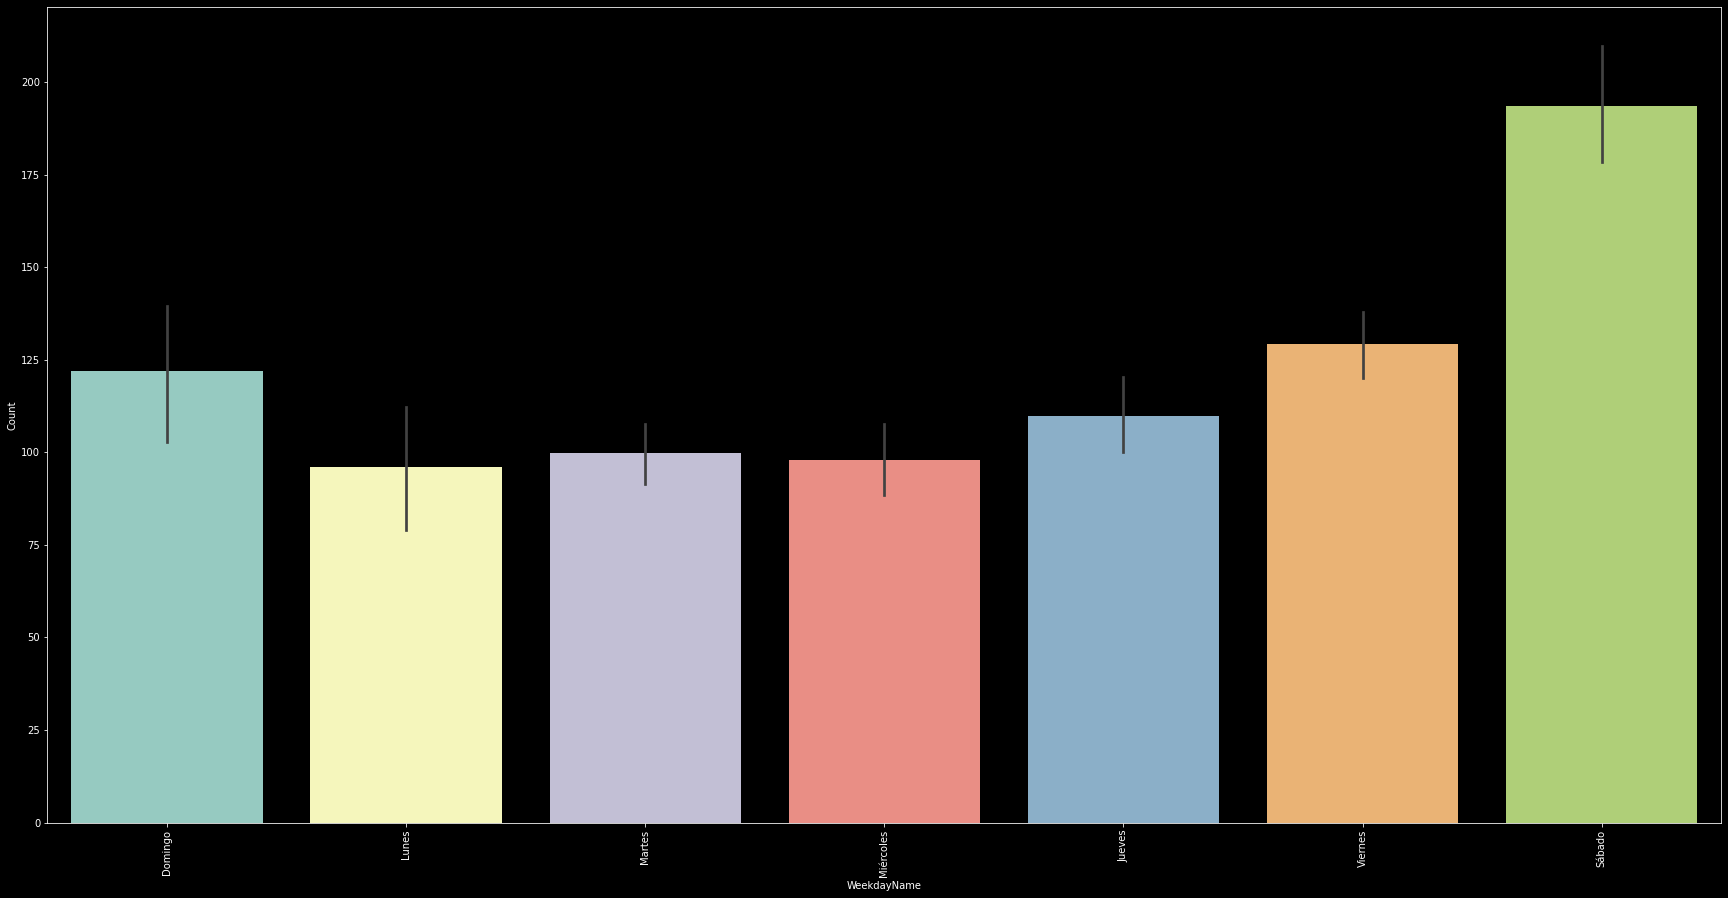

In [54]:
plt.figure(figsize=(30,15))
plt.xticks(rotation=90)
sns.barplot(x="WeekdayName", y="Count", data=group_weekday)

In [55]:
# Ahora desagregamos por horas
time = transacciones_df["Time"]
transactions_per_hour = transacciones_df.groupby([time.dt.hour])["Item"].value_counts().reset_index(name='Count')
transactions_per_hour = transactions_per_hour.groupby(by="Time").sum()
transactions_per_hour

,Count
Time,
1,1
7,23
8,634
9,1899
10,2502
11,2950
12,2792
13,2592
14,2522


In [56]:
# Para poder visualizar las horas donde no ha habido transacciones
transactions_per_hour = transactions_per_hour.reindex([i for i in range(1,24)], fill_value=0)
transactions_per_hour

,Count
Time,
1,1
2,0
3,0
4,0
5,0
6,0
7,23
8,634
9,1899


<AxesSubplot:xlabel='Time', ylabel='Count'>

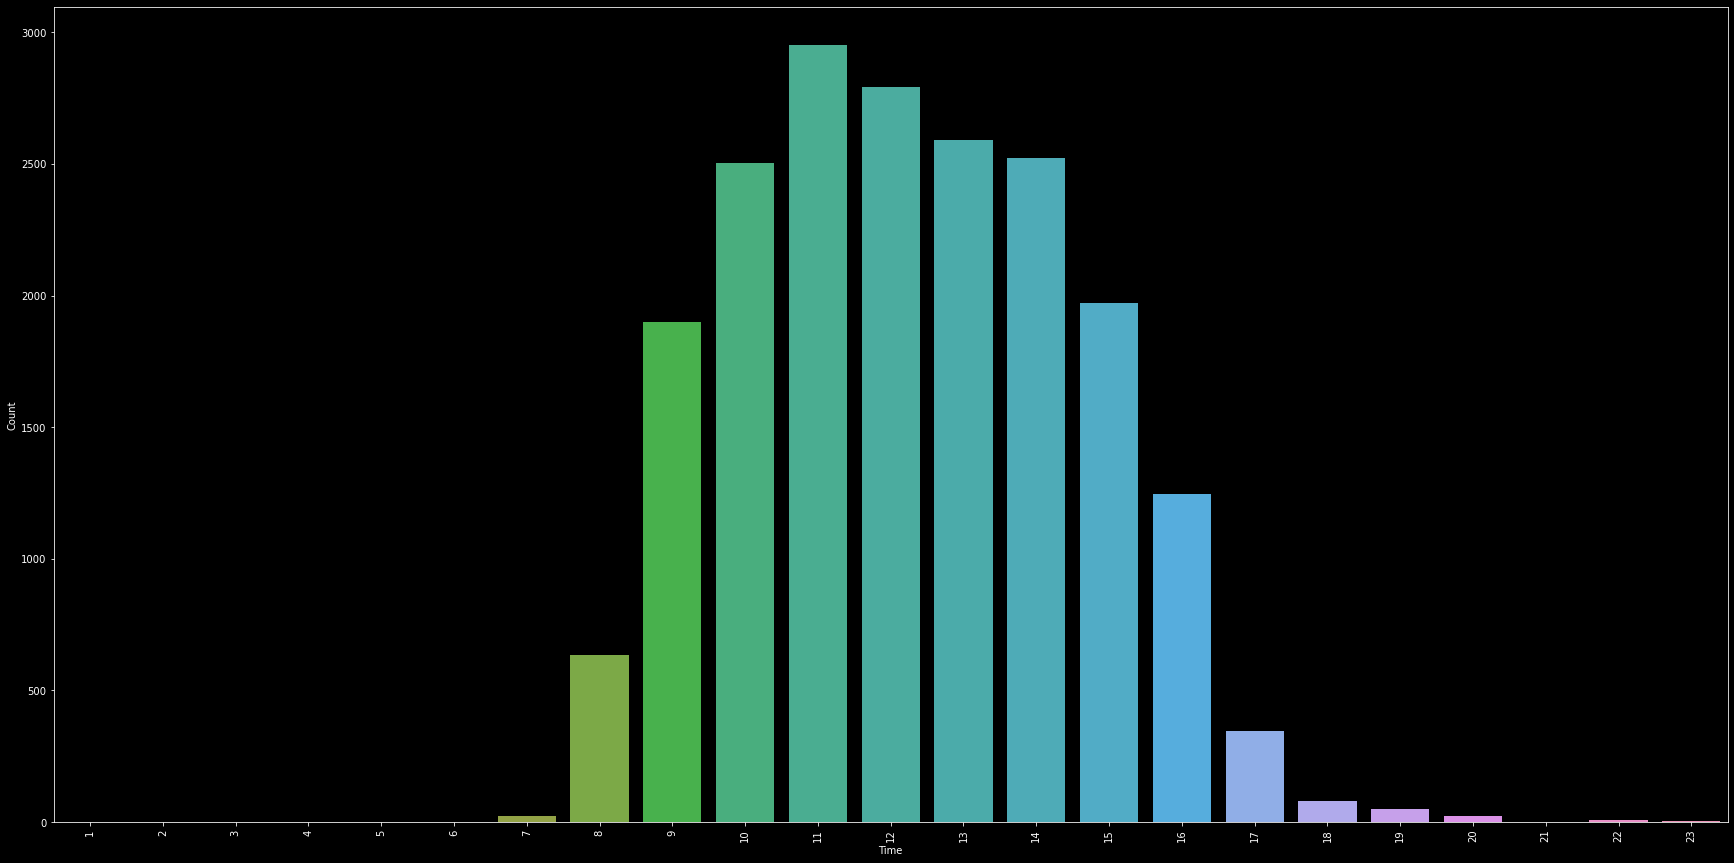

In [57]:
plt.figure(figsize=(30,15))
plt.xticks(rotation=90)
sns.barplot(x=transactions_per_hour.index, y="Count", data = transactions_per_hour)

In [64]:
time = transacciones_df["Time"]
transactions_per_hour_per_item = transacciones_df.groupby([time.dt.hour])["Item"].value_counts().reset_index(name='Count')
transactions_per_hour_per_item_grouped = transactions_per_hour_per_item.groupby(by="Time").sum()
transactions_per_hour_per_item_grouped

,Count
Time,
1,1
7,23
8,634
9,1899
10,2502
11,2950
12,2792
13,2592
14,2522


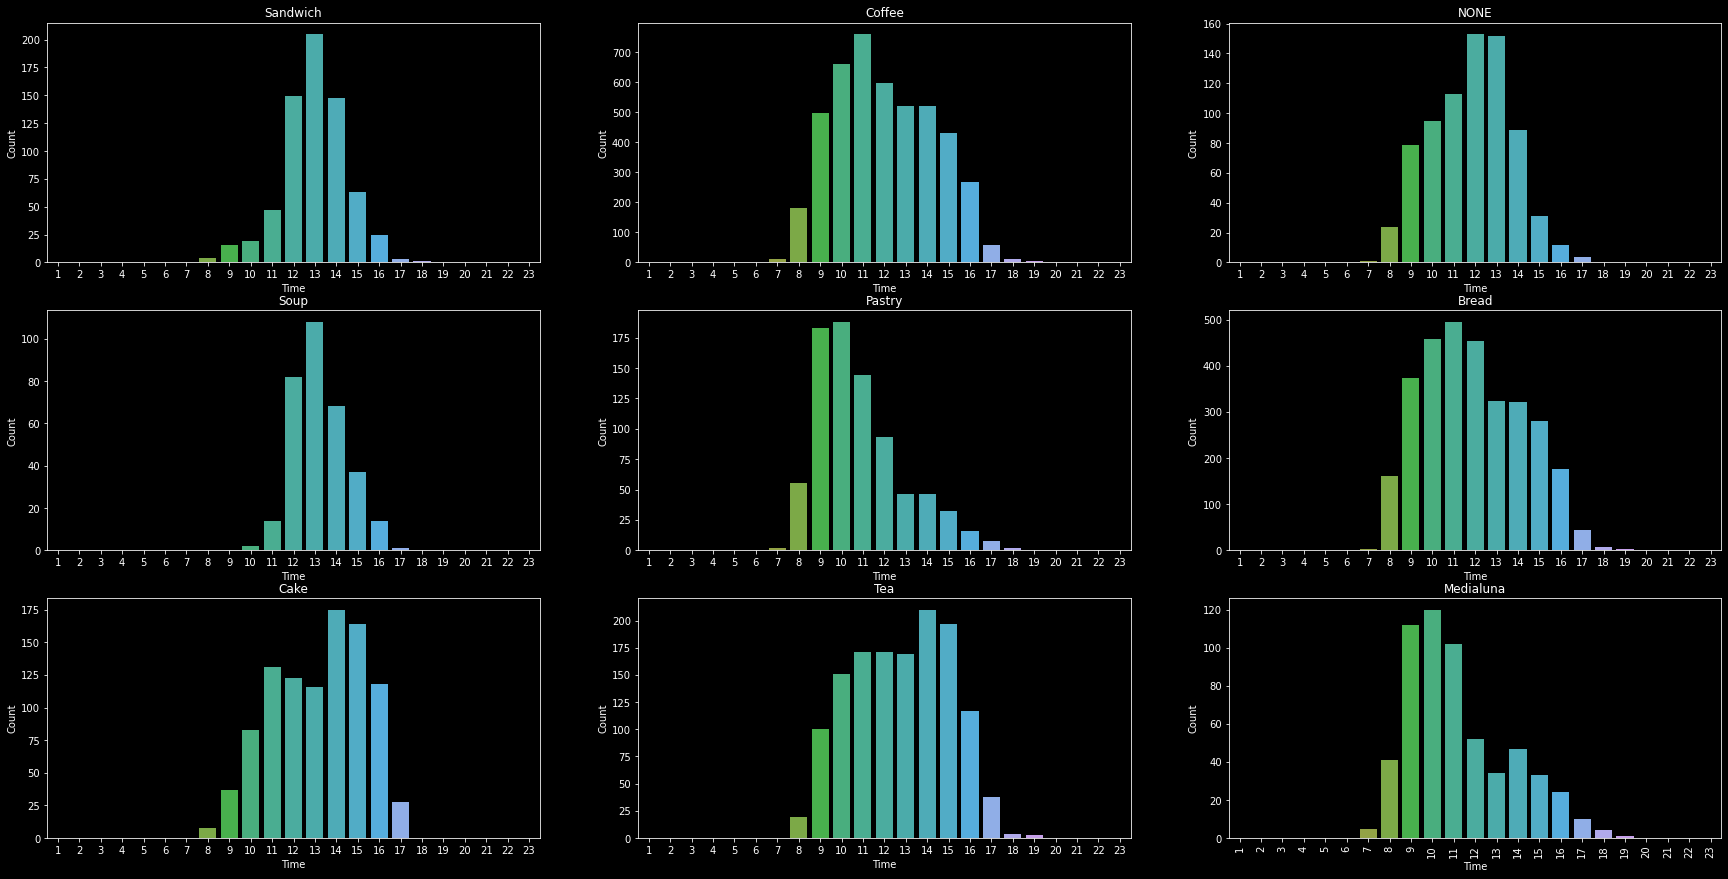

In [63]:
fig, axs = plt.subplots(3, 3,figsize=(30,15))

s1 = set((0, 1, 2))
s2 = set(product(s1, repeat = 2))
# print(s2, len(s2))

for item in transactions_per_hour_per_item.sort_values('Count', ascending=False)["Item"].unique()[:len(s2)]:
    group_item1 = transactions_per_hour_per_item.copy()
    group_item1 = group_item1[group_item1["Item"] == item]

    group_item1.set_index("Time", inplace=True)
    group_item1 = group_item1.reindex([i for i in range(1,24)], fill_value=0)
    
    plt.xticks(rotation=90)
    sns.barplot(ax= axs[s2.pop()], x=group_item1.index, y="Count", data=group_item1).set_title(item)

## Escogiendo nuestros datos
Para este ejemplo vamos a coger como muestra los datos de los fines de semana, por ser los días con más transacciones.
Sabemos además que de media las horas con más transacciones son entre las 10:00 y las 14:00, vamos a comprobar si esto también es cierto los fines de semana.

In [65]:
week_hour = transacciones_df.copy()
week_hour

,Time,Transaction,Item
Date,,,
2016-10-30,1900-01-01 09:58:11,1,Bread
2016-10-30,1900-01-01 10:05:34,2,Scandinavian
2016-10-30,1900-01-01 10:07:57,3,Hot chocolate
2016-10-30,1900-01-01 10:07:57,3,Jam
2016-10-30,1900-01-01 10:07:57,3,Cookies
...,...,...,...
2017-04-09,1900-01-01 14:32:58,9682,Coffee
2017-04-09,1900-01-01 14:32:58,9682,Tea
2017-04-09,1900-01-01 14:57:06,9683,Coffee


In [66]:
week_hour["Weekday"] = week_hour.index.map(lambda x: x.weekday())
week_hour["WeekdayName"] = week_hour["Weekday"].map({0:"Lunes", 1:"Martes", 2:"Miércoles", 3:"Jueves", 4:"Viernes", 5:"Sábado", 6:"Domingo"})

In [67]:
weekend = week_hour[(week_hour["Weekday"] >= 4) & (week_hour["Weekday"] <= 6)]
weekend

,Time,Transaction,Item,Weekday,WeekdayName
Date,,,,,
2016-10-30,1900-01-01 09:58:11,1,Bread,6,Domingo
2016-10-30,1900-01-01 10:05:34,2,Scandinavian,6,Domingo
2016-10-30,1900-01-01 10:07:57,3,Hot chocolate,6,Domingo
2016-10-30,1900-01-01 10:07:57,3,Jam,6,Domingo
2016-10-30,1900-01-01 10:07:57,3,Cookies,6,Domingo
...,...,...,...,...,...
2017-04-09,1900-01-01 14:32:58,9682,Coffee,6,Domingo
2017-04-09,1900-01-01 14:32:58,9682,Tea,6,Domingo
2017-04-09,1900-01-01 14:57:06,9683,Coffee,6,Domingo


In [68]:
time = weekend["Time"]
group = weekend.groupby([time.dt.hour])["Item"].value_counts().reset_index(name='Count')
group_item = group.groupby(by="Time").sum()
# Para poder visualizar las horas donde no ha habido transacciones
group_item = group_item.reindex([i for i in range(1,24)], fill_value=0)
group_item

,Count
Time,
1,1
2,0
3,0
4,0
5,0
6,0
7,2
8,315
9,979


<AxesSubplot:xlabel='Time', ylabel='Count'>

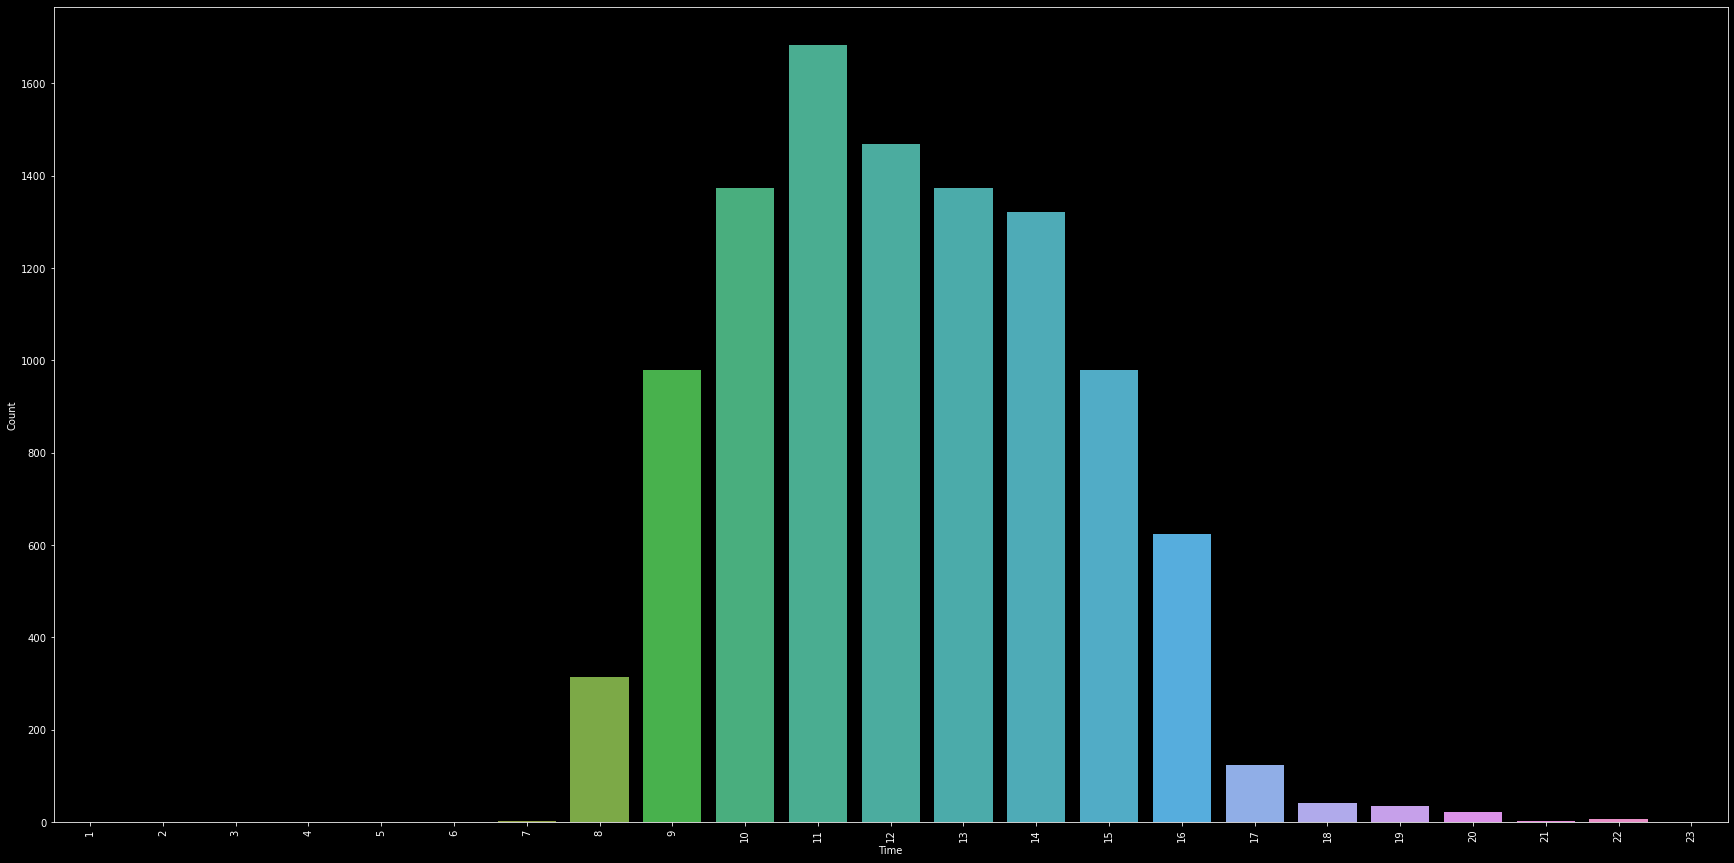

In [69]:
plt.figure(figsize=(30,15))
plt.xticks(rotation=90)
sns.barplot(x=group_item.index, y="Count", data = group_item)

Hemos comprobado que lo fines de semana siguen una distribución parecida a la general. Vamos entonces a trabajar con las transacciones de los fines de semana entre las 10:00 y las 14:00

In [70]:
working_df = weekend[(weekend["Time"].dt.hour >= 10) & (weekend["Time"].dt.hour <= 14)]
working_df

,Time,Transaction,Item,Weekday,WeekdayName
Date,,,,,
2016-10-30,1900-01-01 10:05:34,2,Scandinavian,6,Domingo
2016-10-30,1900-01-01 10:07:57,3,Hot chocolate,6,Domingo
2016-10-30,1900-01-01 10:07:57,3,Jam,6,Domingo
2016-10-30,1900-01-01 10:07:57,3,Cookies,6,Domingo
2016-10-30,1900-01-01 10:08:41,4,Muffin,6,Domingo
...,...,...,...,...,...
2017-04-09,1900-01-01 14:32:58,9682,Tacos/Fajita,6,Domingo
2017-04-09,1900-01-01 14:32:58,9682,Coffee,6,Domingo
2017-04-09,1900-01-01 14:32:58,9682,Tea,6,Domingo


In [71]:
# Además ya no nos interesan ni la hora ni la fecha
working_df.reset_index(inplace=True)
working_df


,Date,Time,Transaction,Item,Weekday,WeekdayName
0,2016-10-30,1900-01-01 10:05:34,2,Scandinavian,6,Domingo
1,2016-10-30,1900-01-01 10:07:57,3,Hot chocolate,6,Domingo
2,2016-10-30,1900-01-01 10:07:57,3,Jam,6,Domingo
3,2016-10-30,1900-01-01 10:07:57,3,Cookies,6,Domingo
4,2016-10-30,1900-01-01 10:08:41,4,Muffin,6,Domingo
...,...,...,...,...,...,...
7214,2017-04-09,1900-01-01 14:32:58,9682,Tacos/Fajita,6,Domingo
7215,2017-04-09,1900-01-01 14:32:58,9682,Coffee,6,Domingo
7216,2017-04-09,1900-01-01 14:32:58,9682,Tea,6,Domingo
7217,2017-04-09,1900-01-01 14:57:06,9683,Coffee,6,Domingo


In [72]:
working_df_dropped = working_df.drop(["Date","Time", "Weekday", "WeekdayName"], axis=1)

### One Hot Encoding to categorical variables


In [73]:
dummies = pd.get_dummies(working_df_dropped, prefix='', prefix_sep='')
dummies.head(5)

,Transaction,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Basket,Bowl Nic Pitt,...,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
dummies = dummies.groupby(by="Transaction").sum()
dummies

,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Basket,Bowl Nic Pitt,Bread,...,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9679,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9680,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9681,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


# Generating Association Rules


In [87]:
# Function by EKREM BAYAR
# url: https://www.kaggle.com/ekrembayar/apriori-association-rules-grocery-store
def ar_iterations(data, num_iter = 1, support_value = 0.005, iterationIndex = None):
    
    # Next Iterations
    def ar_calculation(iterationIndex = iterationIndex): 
        # Calculation of support value
        value = []
        for i in range(0, len(iterationIndex)):
            result = data.T.loc[iterationIndex[i]].sum() 
            result = len(result[result == data.T.loc[iterationIndex[i]].shape[0]]) / data.shape[0]
            value.append(result)
        # Bind results
        result = pd.DataFrame(value, columns = ["Support"])
        result["index"] = [tuple(i) for i in iterationIndex]
        result['length'] = result['index'].apply(lambda x:len(x))
        result = result.set_index("index").sort_values("Support", ascending = False)
        # Elimination by Support Value
        result = result[result.Support > support_value]
        return result    
    
    # First Iteration
    first = pd.DataFrame(dummies.T.sum(axis = 1) / dummies.shape[0], columns = ["Support"]).sort_values("Support", ascending = False)
    first = first[first.Support > support_value]
    first["length"] = 1
    
    if num_iter == 1:
        res = first.copy()
        
    # Second Iteration
    elif num_iter == 2:
        
        second = list(itertools.combinations(first.index, 2))
        second = [list(i) for i in second]
        res = ar_calculation(second)
        
    # All Iterations > 2
    else:
        nth = list(itertools.combinations(set(list(itertools.chain(*iterationIndex))), num_iter))
        nth = [list(i) for i in nth]
        res = ar_calculation(nth)
    
    return res

In [88]:
iteration1 = ar_iterations(dummies, num_iter=1, support_value=0.05)
iteration1

,Support,length
Coffee,0.477852,1
Bread,0.341626,1
Tea,0.126820,1
NONE,0.104066,1
Cake,0.101335,1
Sandwich,0.083434,1
Pastry,0.077063,1
Medialuna,0.066748,1
Hot chocolate,0.058556,1
Scone,0.054915,1


In [89]:
iteration2 = ar_iterations(dummies, num_iter=2, support_value=0.05)
iteration2

,Support,length
index,,
"(Coffee, Bread)",0.099211,2
"(Coffee, NONE)",0.056432,2
"(Coffee, Cake)",0.053095,2


In [90]:
iteration3 = ar_iterations(dummies, num_iter=3, support_value=0.01,
              iterationIndex=iteration2.index)
iteration3

,Support,length
index,,
"(Coffee, Bread, NONE)",0.013046,3
"(Coffee, Bread, Cake)",0.011529,3


In [91]:
iteration4 = ar_iterations(dummies, num_iter=4, support_value=0.001,
              iterationIndex=iteration3.index)
iteration4

,Support,length
index,,
"(Coffee, Bread, Cake, NONE)",0.001517,4


In [92]:
freq_items = apriori(dummies, min_support = 0.04, use_colnames = True, verbose = 1)
freq_items.sort_values("support", ascending = False)

Processing 60 combinations | Sampling itemset size 32


,support,itemsets
3,0.477852,(Coffee)
0,0.341626,(Bread)
14,0.126820,(Tea)
9,0.104066,(NONE)
2,0.101335,(Cake)
15,0.099211,"(Coffee, Bread)"
11,0.083434,(Sandwich)
10,0.077063,(Pastry)
7,0.066748,(Medialuna)
5,0.058556,(Hot chocolate)


In [93]:
df_ar = association_rules(freq_items, metric = "confidence", min_threshold = 0.5)
df_ar.sort_values(by="lift", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Medialuna),(Coffee),0.066748,0.477852,0.042172,0.631818,1.322205,0.010277,1.418180
3,(Pastry),(Coffee),0.077063,0.477852,0.044296,0.574803,1.202890,0.007471,1.228015
4,(Sandwich),(Coffee),0.083434,0.477852,0.047330,0.567273,1.187131,0.007461,1.206645
2,(NONE),(Coffee),0.104066,0.477852,0.056432,0.542274,1.134816,0.006704,1.140744
0,(Cake),(Coffee),0.101335,0.477852,0.053095,0.523952,1.096474,0.004672,1.096839


# Interpretación de negocio

- Descartamos la regla con antecedente "NONE".
- Descartamos la regla "Cake -> Coffee" por tener un lift demasiado bajo.

Vamos entonces a centrarnos en las 3 reglas restantes:

    1. Medialuna -> Coffee
    2. Pastry -> Coffee
    3. Sandwich -> Coffee

Se tratan de reglas poco frecuentes (pues solo aparecen en un ~4% de las transacciones estudiadas).

Suposiciones:
- Precio final Medialuna: 0.70 €
- Precio final Pastry: 2.29 €
- Precio final Sandwich: 2.72 €
- Precio final Coffee: 2.00 €

### En cada transacción debemos tener en cuenta varios factores:

- Los clientes que actualmente compran el antecedente pero no el consecuente.
- Los clientes que actualmente compran el antecedente y el consecuente.

Tomamos la primera regla como ejemplo.

**Medialuna -> Coffee**

Clientes que compran "Medialuna" pero no "Coffee". Esto puede calcularse como el soporte de Medialuna menos el soporte de "Medialuna -> Coffee".
Como vemos en la tabla de arriba:
- Soporte de "Medialuna" = 0.066748
- Soporte de la regla = 0.042172



In [94]:
print("Clientes que compran 'Medialuna' pero no 'Coffee': {0}%".format(round((0.066748-0.042172)*100,2)))

Clientes que compran 'Medialuna' pero no 'Coffee': 2.46%


- Clientes que compran 'Medialuna' pero no 'Coffee': 2.46%
- Clientes que ya compran "Medialuna" y "Coffee". Esto es el soporte de la regla: 4.2172%

Para referencia obtenemos unos datos básicos:


In [95]:
total_transact = working_df["Transaction"].count()
print("Número total de transacciones en el periodo: ", total_transact)

Número total de transacciones en el periodo:  7219


In [96]:
total_days = len(working_df.groupby(by="Date").count().index)
print("Número total de días en el periodo: ", total_days)

Número total de días en el periodo:  68


In [97]:
print("Media de transacciones por fin de semana: ", round(total_transact/(total_days / 3)))

Media de transacciones por fin de semana:  318


Tenemos entonces que en un fin de semana cualquiera ocurren 318 transacciones, de las cuales aproximadamente 8 serán "Medialunas" sin café y 13 serán "Medialunas" con café.

Obtenemos entonces ingresos por valor de: 

```8*0.7 + 13*(0.7 + 2) = 40.7 €```

Dado que el lift es de 1.322205, podemos estimar entonces que un cliente que compró una "Medialuna" es un 32% más probable que compre café.

Por lo que si se le presentase a estos clientes la opción de comprar café de manera más sencilla o a un coste reducido podríamos generar ventas de café adicionales en 3 de cada 10 clientes.

Suponiendo que conseguimos esas ventas adicionales sin gasto adicional (colocación de producto, recomendación activa de compra... ):

    - De las 8 ventas "Medialunas", 2 (para ser conservadores) se convierten en ventas de café y "Medialuna".
    - Tenemos entonces 6 ventas de "Mediluna" y 15 ventas de café y "Medialuna".
```6*0.7 + 15*(0.7 + 2) = 44.7 €```

Un total de 4€ adicionales de beneficio, puesto que no hemos incurrido en ningún coste extra.


Análogamente se realiza este ejercicio para las otras 2 reglas de asociación:

**Pastry -> Coffee:**
- Soporte de "Pastry" = 0.077063
- Soporte de la regla = 0.044296
- Soporte de los clientes potenciales = 0.077063 - 0.044296 = 0.032767
- Número de clientes que solo compran "Pastry" en un fin de semana:  318*0.032767 = ~10
- Número de clientes que compran "Pastry" + "Coffee" en un fin de semana: 318*0.044296= ~14

- Ingresos hoy: 
```10*2.29 + 14*(2.29 + 2) = 82.96 €```
- Ingresos asumiendo la conversión sin costes de un 20% de los clientes que solo compran "Pastry": 
```8*2.29 + 16*(2.29 + 2) = 86.96 €```
- Beneficio: 4€ por fin de semana

**Sandwich -> Coffee:**
- Soporte de "Sandwich" = 0.083434
- Soporte de la regla = 0.047330
- Soporte de los clientes potenciales = 0.083434 - 0.047330 = 0.036104
- Número de clientes que solo compran "Sandwich" en un fin de semana:  318*0.036104 = ~11
- Número de clientes que compran "Sandwich" + "Coffee" en un fin de semana: 318*0.047330= ~15

- Ingresos hoy: 
```11*2.72 + 15*(2.72 + 2) = 100.72 €```
- Ingresos asumiendo la conversión sin costes de un 18% de los clientes que solo compran "Sandwich": 
```9*2.72 + 17*(2.72 + 2) = 104.72 €```
- Beneficio: 4€ por fin de semana



# Conclusión

Con la aplicación de esas 3 sencillas reglas podemos sacar 12€ adicionales por fin de semana, lo cual equivale a unos 624€ a lo largo del año siempre y cuando haya igualdad de circunstancias.

Si fuera posible además extrapolar estas reglas a los días de entre semana, podría llegarse a obtener 28€ semanales, que a lo largo del año asumiendo igualdad de circunstancias ascienden a 1456€. Esto sería claro está, asumiendo mismo volumen de transacciones y misma distribución en cuanto a tipo de objetos vendidos, lo cual no parece realista (no parece que el café se vaya a vender tan bien en verano); habría por tanto, que reducir la cifra anteriormente mencionada. En cualquier caso, existe un margen de mejora potencial aunque las reglas halladas no sean de gran frecuencia o de alta confianza. 

En el caso pesimista en el que es necesario rebajar el precio del café para conseguir la compra del consecuente y tenemos en cuenta que las transacciones entre semana son menos numerosas; asumiendo que podemos conseguir una ganancia de 1€ por día (frente a los 4€ diaríos estimados), supondría una ganancia de 365€ anuales, algo nada desdeñable.

Lo realmente interesante sería tener acceso a los márgenes netos de los productos, pues un incremento mayor de los ingresos no tiene por qué traducirse a un incremento mayor de los beneficios. Sería recomendable tener en cuenta los márgenes para poder ponderar la utilidad de las reglas e intentar estimular las ventas de productos con mejores márgenes.
